In [2]:

import os
import cv2
from glob import glob

# Dataset base directory (automatically mounted by Kaggle)
base_dir ='/kaggle/input/ff-c23/FaceForensics++_C23'


# Check available folders
os.listdir(base_dir)


['Face2Face',
 'csv',
 'Deepfakes',
 'DeepFakeDetection',
 'original',
 'NeuralTextures',
 'FaceShifter',
 'FaceSwap']

In [3]:
video_paths = glob(os.path.join(base_dir, '**', '*.mp4'), recursive=True)

print(f"Total videos found: {len(video_paths)}")
for v in video_paths[:5]:
    print(v)


Total videos found: 7000
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/481_469.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/184_205.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/315_322.mp4
/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/645_688.mp4


In [4]:
deepfake_video = next((v for v in video_paths if 'Deepfakes' in v), None)
face2face_video = next((v for v in video_paths if 'Face2Face' in v), None)
original_video = next((v for v in video_paths if 'original' in v), None)

print("🎞️ Deepfakes:", deepfake_video)
print("🎞️ Face2Face:", face2face_video)
print("🎞️ Original:", original_video)


🎞️ Deepfakes: /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4
🎞️ Face2Face: /kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4
🎞️ Original: /kaggle/input/ff-c23/FaceForensics++_C23/original/123.mp4


# **FRAME EXTRACTION**

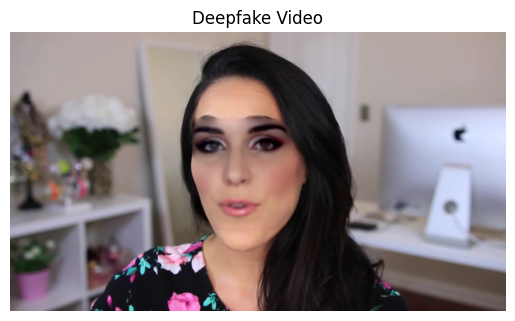

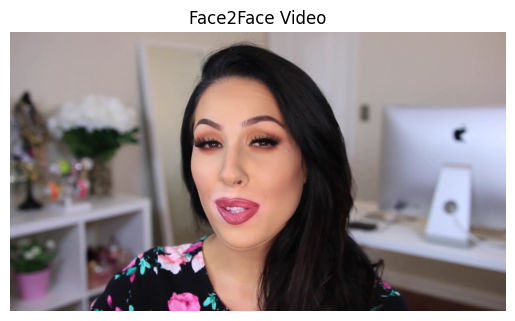

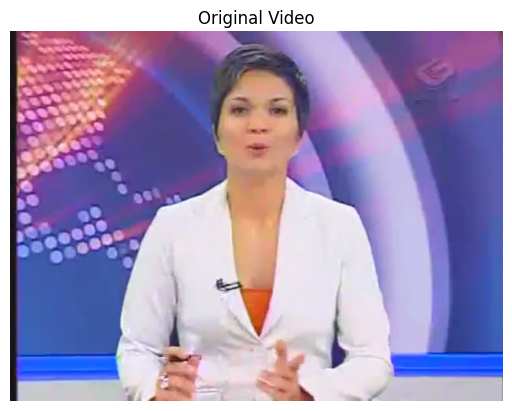

In [5]:
import cv2
import matplotlib.pyplot as plt

def show_first_frame(video_path, title=""):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"❌ Couldn't read frame from {video_path}")

# Preview
show_first_frame(deepfake_video, "Deepfake Video")
show_first_frame(face2face_video, "Face2Face Video")
show_first_frame(original_video, "Original Video")


In [6]:
def extract_frames(video_path, frame_interval=30):  # ~30 fps → 1 frame/sec
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1
    
    cap.release()
    return frames

# Example: extract frames from each video
df_frames = extract_frames(deepfake_video)
f2f_frames = extract_frames(face2face_video)
orig_frames = extract_frames(original_video)

print(f"Deepfake: {len(df_frames)} frames | Face2Face: {len(f2f_frames)} | Original: {len(orig_frames)}")


Deepfake: 17 frames | Face2Face: 11 | Original: 18


#  **FACE DETECTION AND CROPPING**

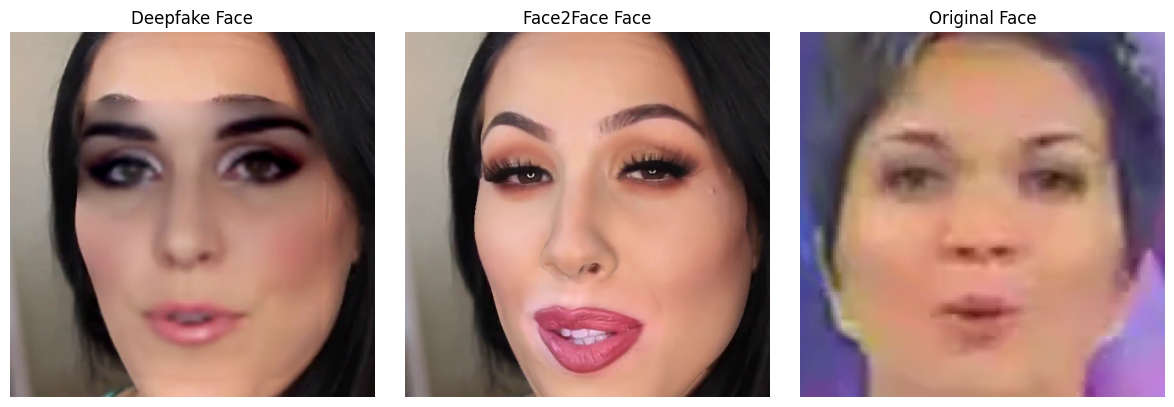

In [7]:
import cv2
import matplotlib.pyplot as plt

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 1. Extract frames at 1 fps (~30 fps video → every 30th frame)
def extract_frames(video_path, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frames.append(frame)
        count += 1
    cap.release()
    return frames

# 2. Detect and crop faces
def detect_faces(frames):
    face_crops = []
    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face_crops.append(face)
            break  # one face per frame
    return face_crops

# === Process videos ===
df_faces = detect_faces(extract_frames(deepfake_video))
f2f_faces = detect_faces(extract_frames(face2face_video))
orig_faces = detect_faces(extract_frames(original_video))

# === Show one sample face per video ===
titles = ["Deepfake", "Face2Face", "Original"]
faces = [df_faces, f2f_faces, orig_faces]

plt.figure(figsize=(12, 4))
for i, (title, face_list) in enumerate(zip(titles, faces)):
    if face_list:
        plt.subplot(1, 3, i+1)
        plt.imshow(cv2.cvtColor(face_list[0], cv2.COLOR_BGR2RGB))
        plt.title(f"{title} Face")
        plt.axis('off')
    else:
        print(f"[!] No face found in {title} video.")

plt.tight_layout()
plt.show()


# **COMPRESSION ARTIFACT VISUALIZATION**

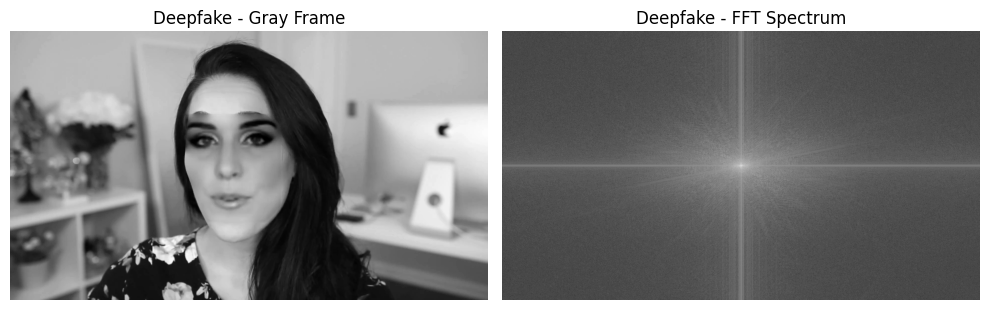

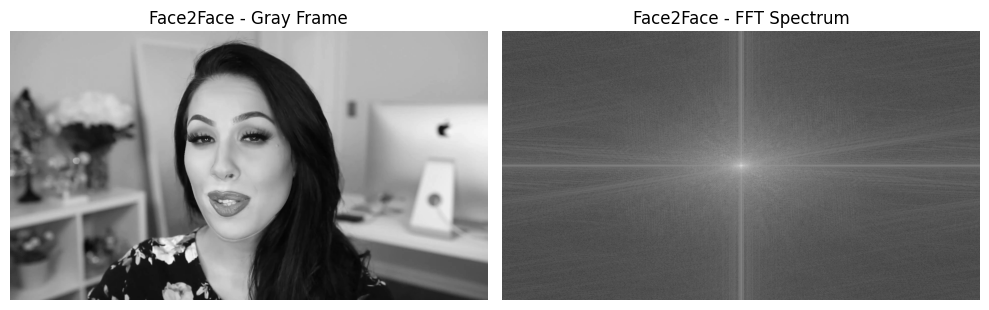

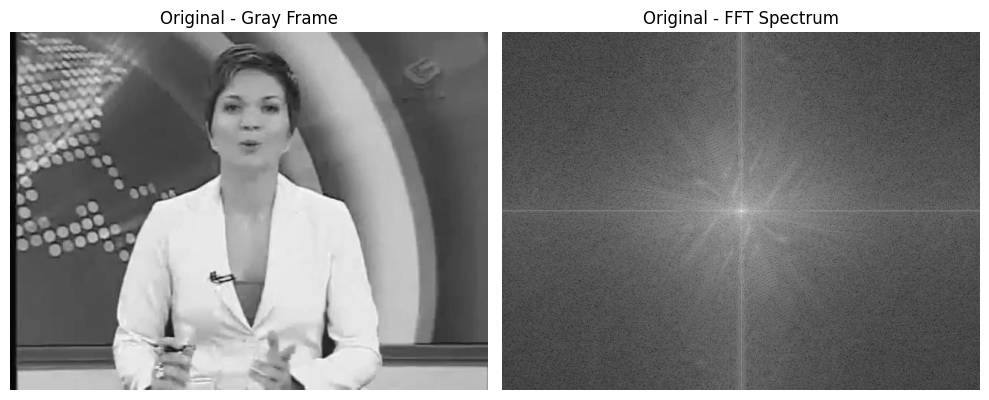

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_compression_artifact(frame, title_prefix=""):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(gray, cmap='gray')
    plt.title(f"{title_prefix} - Gray Frame")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f"{title_prefix} - FFT Spectrum")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for first frame of each video
visualize_compression_artifact(df_frames[0], title_prefix="Deepfake")
visualize_compression_artifact(f2f_frames[0], title_prefix="Face2Face")
visualize_compression_artifact(orig_frames[0], title_prefix="Original")


# **TEMPORAL DIFFERENCE** # 

Checking video paths:
Original exists: True
DeepFake exists: True
Face2Face exists: True
Extracted 18 frames from /kaggle/input/ff-c23/FaceForensics++_C23/original/123.mp4
Extracted 17 frames from /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4
Extracted 11 frames from /kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4
Comparing 11 aligned frames.

Showing comparison for Frame 1


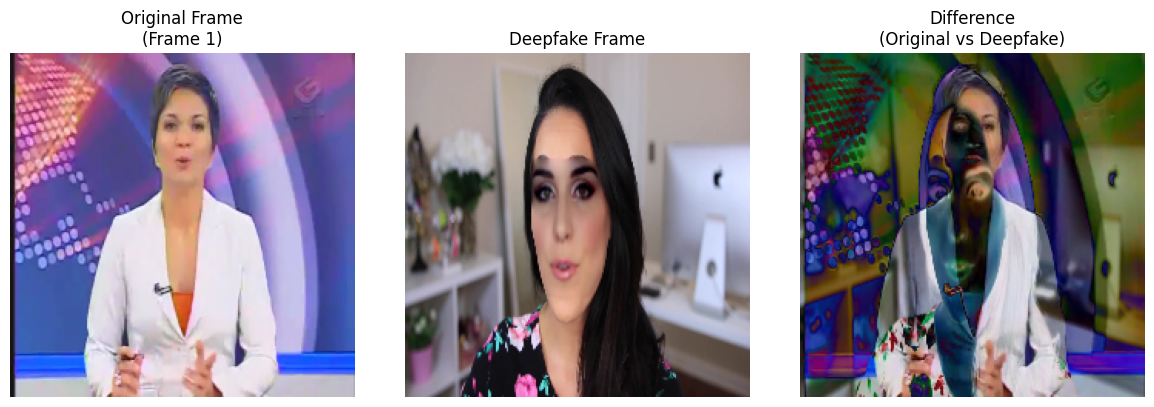

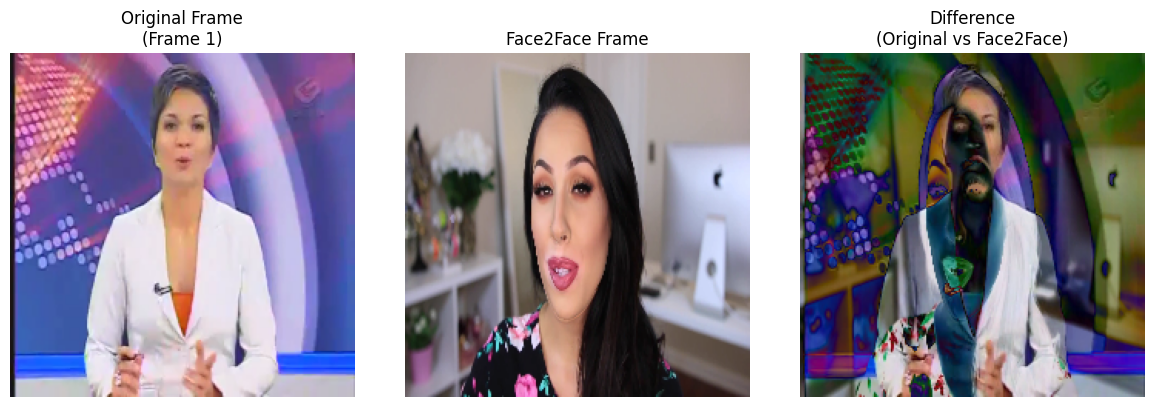


Showing comparison for Frame 2


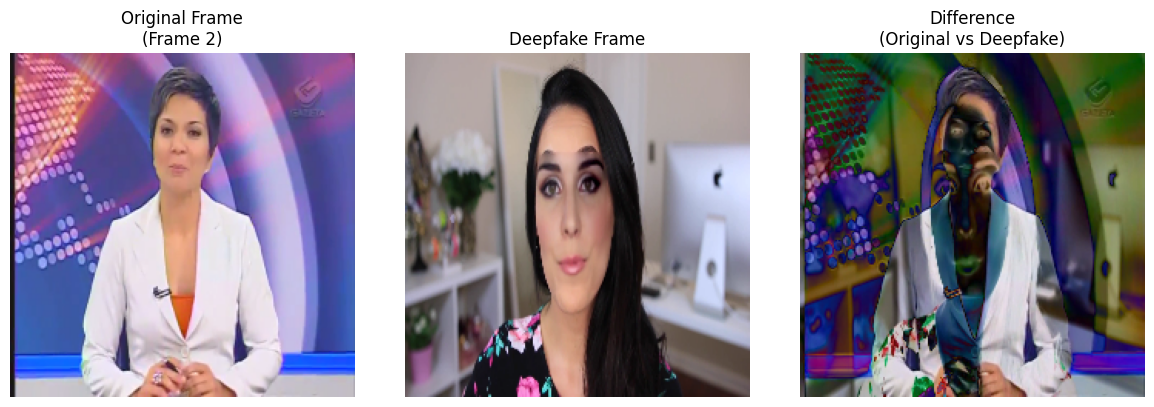

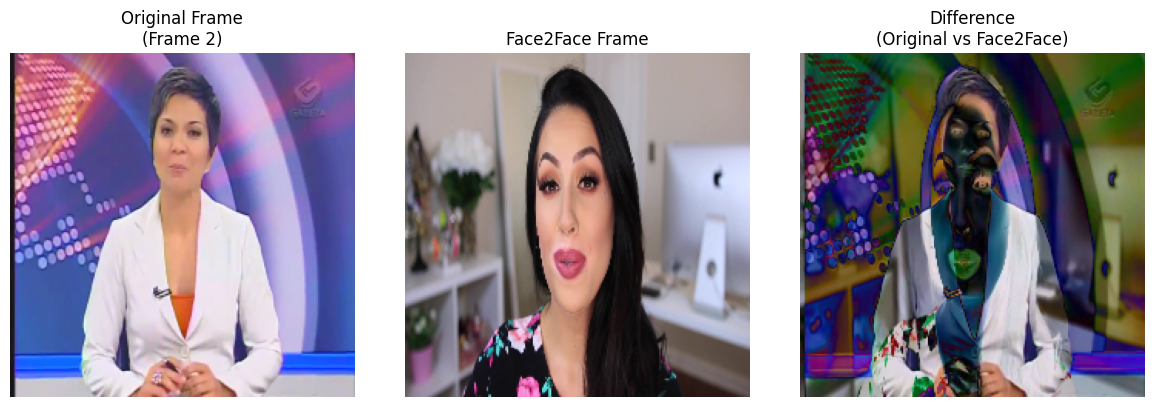


Showing comparison for Frame 3


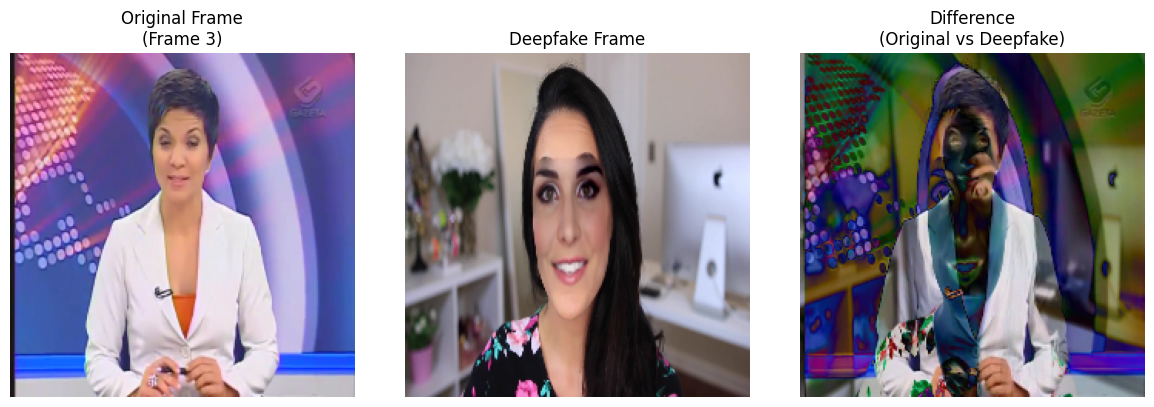

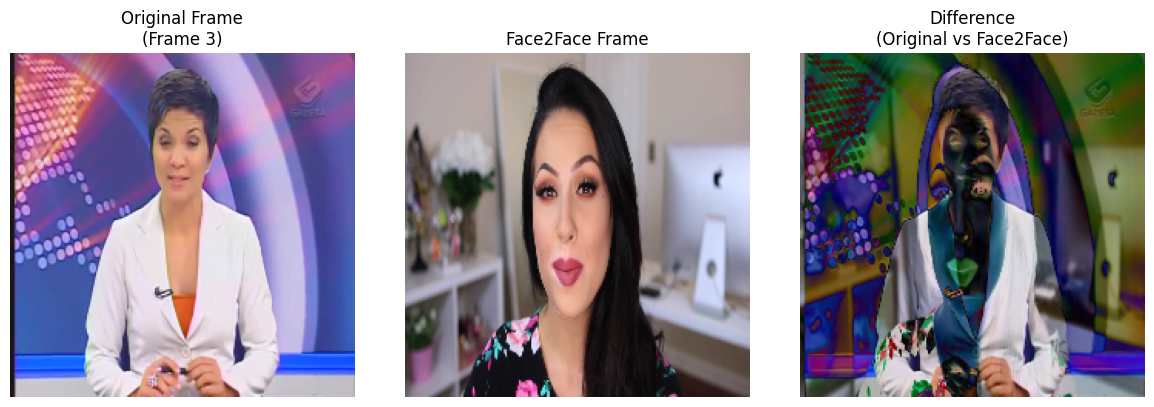

In [25]:
import cv2
import matplotlib.pyplot as plt
import os

# --- 1. Set video paths ---
DeepFake_video = "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4"
Face2Face_video = "/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4"
original_video = "/kaggle/input/ff-c23/FaceForensics++_C23/original/123.mp4"

# --- 2. Check if files exist ---
print("Checking video paths:")
print("Original exists:", os.path.exists(original_video))
print("DeepFake exists:", os.path.exists(DeepFake_video))
print("Face2Face exists:", os.path.exists(Face2Face_video))

# --- 3. Frame extraction function ---
def extract_frames(video_path, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return []

    frames = []
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {len(frames)} frames from {video_path}")
    return frames

# --- 4. Resize frames to common size before comparison ---
def resize_frame(frame, size=(224, 224)):  # Resize to 224x224 or any common size
    return cv2.resize(frame, size)

# --- 5. Visualization function ---
def show_temporal_difference(original_frame, compare_frame, label="", video_name=""):
    # Resize both frames to ensure they are the same size
    original_frame = resize_frame(original_frame)
    compare_frame = resize_frame(compare_frame)

    diff = cv2.absdiff(original_frame, compare_frame)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Frame\n({video_name})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(compare_frame, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} Frame")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
    plt.title(f"Difference\n(Original vs {label})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 6. Extract frames ---
original_frames = extract_frames(original_video)
df_frames = extract_frames(DeepFake_video)
f2f_frames = extract_frames(Face2Face_video)

# --- 7. Truncate to equal length ---
min_len = min(len(original_frames), len(df_frames), len(f2f_frames))
original_frames = original_frames[:min_len]
df_frames = df_frames[:min_len]
f2f_frames = f2f_frames[:min_len]

print(f"Comparing {min_len} aligned frames.")

# --- 8. Show visual comparison (limit to 3 frames to avoid overload) ---
for i in range(min(3, min_len)):
    print(f"\nShowing comparison for Frame {i+1}")
    show_temporal_difference(original_frames[i], df_frames[i], label="Deepfake", video_name=f"Frame {i+1}")
    show_temporal_difference(original_frames[i], f2f_frames[i], label="Face2Face", video_name=f"Frame {i+1}")


# **FREQUENCY DOMAIN TRANSFORMATION**

Video found: /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4
Extracted 17 frames from /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4

Processing Frame 1


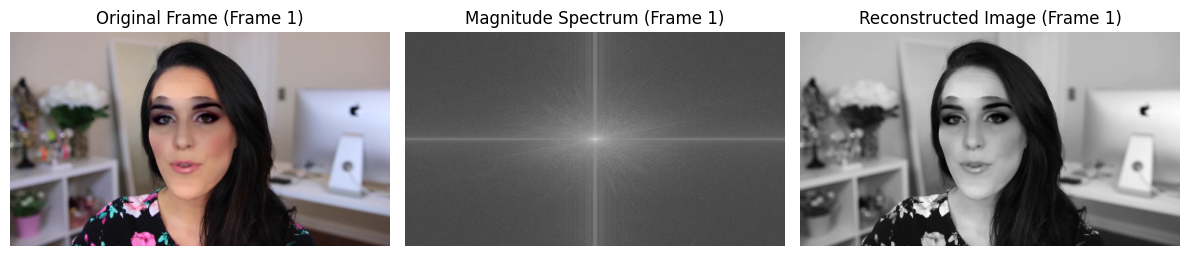


Processing Frame 2


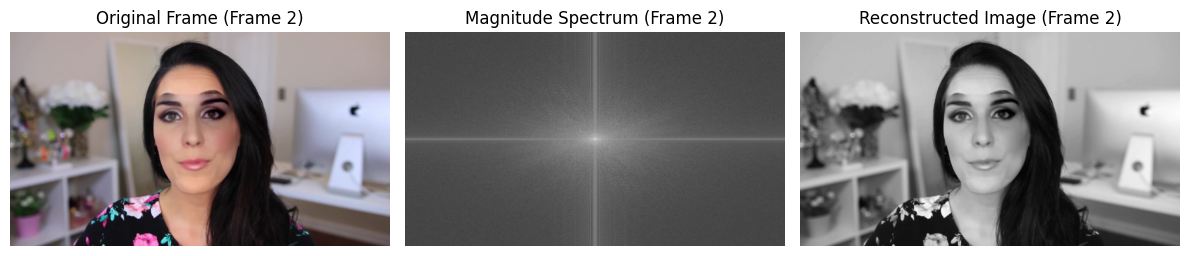


Processing Frame 3


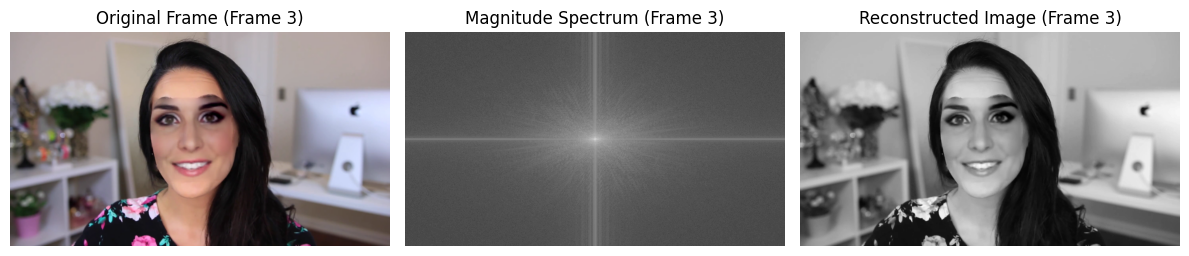

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Set video path ---
video_path = "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4"  # Example video

# --- 2. Check if file exists ---
if not os.path.exists(video_path):
    print(f"Video not found: {video_path}")
else:
    print(f"Video found: {video_path}")

# --- 3. Frame extraction function ---
def extract_frames(video_path, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return []

    frames = []
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {len(frames)} frames from {video_path}")
    return frames

# --- 4. Resize frames to common size before comparison ---
def resize_frame(frame, size=(224, 224)):  # Resize to 224x224 or any common size
    return cv2.resize(frame, size)

# --- 5. Fourier Transform functions ---
def apply_fourier_transform(frame):
    """Apply Fourier Transform to an image."""
    # Convert to grayscale for simplicity
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Perform Fourier Transform (2D)
    f = np.fft.fft2(gray_frame)
    fshift = np.fft.fftshift(f)  # Shift zero frequency component to the center
    
    # Calculate the magnitude and phase spectrum
    magnitude_spectrum = np.abs(fshift)
    phase_spectrum = np.angle(fshift)
    
    return fshift, magnitude_spectrum, phase_spectrum

def inverse_fourier_transform(fshift):
    """Apply Inverse Fourier Transform to the frequency domain image."""
    # Inverse FFT to get the image back
    f_ishift = np.fft.ifftshift(fshift)  # Shift back to original position
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)  # Convert back to real values
    
    return img_back

# --- 6. Process video frames and show frequency domain ---
frames = extract_frames(video_path)

# Show frequency domain for first 3 frames (for brevity)
for i in range(min(3, len(frames))):
    print(f"\nProcessing Frame {i+1}")

    # Apply Fourier Transform
    fshift, mag_spectrum, phase_spectrum = apply_fourier_transform(frames[i])
    img_back = inverse_fourier_transform(fshift)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Original Frame (Frame {i+1})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.log(mag_spectrum + 1), cmap='gray')  # Log scale for better visibility
    plt.title(f"Magnitude Spectrum (Frame {i+1})")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_back, cmap='gray')
    plt.title(f"Reconstructed Image (Frame {i+1})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
